In [ ]:
import torch
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import scipy
from datetime import datetime
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.insert(0, module_path)
print(sys.path)

import Double_Pendulum.Learning.autoencoders as autoencoders
import Double_Pendulum.robot_parameters as robot_parameters
import Double_Pendulum.transforms as transforms
import Double_Pendulum.dynamics as dynamics
import Plotting.pendulum_plot as pendulum_plot

from functools import partial

import matplotlib
matplotlib.rcParams['font.family']   = 'serif'
matplotlib.rcParams['font.serif']    = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

from matplotlib.ticker import ScalarFormatter




%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code', '/home/kian/anaconda3/envs/thesis2/lib/python311.zip', '/home/kian/anaconda3/envs/thesis2/lib/python3.11', '/home/kian/anaconda3/envs/thesis2/lib/python3.11/lib-dynload', '', '/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def load_performance_dict(load_performance_path):
	performance_dict = torch.load(load_performance_path)#, map_location = "cpu")
	print(f"Loaded performance dicts from {load_performance_path}")
	return performance_dict

In [144]:
def make_boxplot(values_nn, values_ana, values_q, plot_title, ylabel):
	fig, ax = plt.subplots(figsize=(3, 2))
	ax.set_ylabel(ylabel)
	ax.set_title(plot_title)

	boxdata = [values_nn, values_ana, values_q]
	colors = ["tab:orange", "tab:blue", "tab:green"]
	labels = ["Learned", "Analytic", "Naive"]

	bplot = ax.boxplot(boxdata,
					patch_artist=True,  # fill with color
					tick_labels=labels)  # will be used to label x-ticks
	
	for median in bplot["medians"]:
		median.set_color("black")

	# fill with colors
	for patch, color in zip(bplot['boxes'], colors):
		patch.set_facecolor(color)
	plt.grid(linestyle="--", axis="y")
	plt.show()

def make_boxplots_2x2(values_nn, values_ana, values_q, plot_titles, ylabels, yscientifics, save_name, figsize=(5, 4)):
	"""
	Create a 2x2 grid of boxplots for the provided data series.

	Parameters
	----------
	values_nn : list of array-like
		List of four arrays (one per subplot) of neural net errors.
	values_ana : list of array-like
		List of four arrays (analytic errors).
	values_q : list of array-like
		List of four arrays (naive errors).
	plot_titles : list of str
		Titles for each subplot (length 4).
	ylabels : list of str
		Y-axis labels for each subplot (length 4).
	yscientific : list of booleans
		Whether to display ylabel in scientific notation
	figsize : tuple, optional
		Figure size (width, height) in inches.
	"""
	fig, axes = plt.subplots(2, 2, figsize=figsize)
	axes = axes.flatten()

	labels = ["Learned", "Analytic", "Naive"]
	colors = ["tab:orange", "tab:blue", "tab:green"]

	# Loop over axes and data
	for ax, nn, ana, q, title, ylabel, yscientific in zip(
		axes, values_nn, values_ana, values_q, plot_titles, ylabels, yscientifics
	):
		ax.set_title(title)
		ax.set_ylabel(ylabel)

		# Collect data for this subplot
		boxdata = [nn, ana, q]
		bplot = ax.boxplot(
			boxdata,
			patch_artist=True,
			tick_labels=labels,
			showfliers=False
		)

		if yscientific:
			ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
			ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
		ax.tick_params(axis='y', labelrotation=90, pad=0)
		# Style medians
		for median in bplot['medians']:
			median.set_color('black')

		# Fill boxes
		for patch, color in zip(bplot['boxes'], colors):
			patch.set_facecolor(color)

		ax.grid(linestyle='--', axis='y')


	plt.tight_layout()
	plt.savefig(save_name +".pdf", format = "pdf")
	plt.show()
	

#### Undamped

In [95]:
dict_save_dir = "collocated_results/performance_logs/undamped"
dict_save_names = ["pdata_nn_sims_undamped.pt", "pdata_ana_sims_undamped.pt", "pdata_naive_sims_undamped.pt"]

pdata_nn_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[0])
pdata_ana_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[1])
pdata_naive_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[2])

Loaded performance dicts from collocated_results/performance_logs/undamped/pdata_nn_sims_undamped.pt
Loaded performance dicts from collocated_results/performance_logs/undamped/pdata_ana_sims_undamped.pt
Loaded performance dicts from collocated_results/performance_logs/undamped/pdata_naive_sims_undamped.pt


/tmp/ipykernel_9478/2071993885.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict = torch.load(load_performance_path)#, map_location = "cpu")


In [147]:
dict_save_dir10 = "collocated_results/performance_logs/damped_c=" + str(10)
dict_save_names10 = ["pdata_nn_sims.pt", "pdata_ana_sims.pt", "pdata_naive_sims.pt"]

pdata_nn_sims_damp10 = load_performance_dict(dict_save_dir10 + "/" + dict_save_names10[0])
pdata_ana_sims_damp10 = load_performance_dict(dict_save_dir10 + "/" + dict_save_names10[1])
pdata_naive_sims_damp10 = load_performance_dict(dict_save_dir10 + "/" + dict_save_names10[2])

dict_save_dir50 = "collocated_results/performance_logs/damped_c=" + str(50)
dict_save_names50 = ["pdata_nn_sims.pt", "pdata_ana_sims.pt", "pdata_naive_sims.pt"]

pdata_nn_sims_damp50 = load_performance_dict(dict_save_dir50 + "/" + dict_save_names50[0])
pdata_ana_sims_damp50 = load_performance_dict(dict_save_dir50 + "/" + dict_save_names50[1])
pdata_naive_sims_damp50 = load_performance_dict(dict_save_dir50 + "/" + dict_save_names50[2])

Loaded performance dicts from collocated_results/performance_logs/damped_c=10/pdata_nn_sims.pt
Loaded performance dicts from collocated_results/performance_logs/damped_c=10/pdata_ana_sims.pt
Loaded performance dicts from collocated_results/performance_logs/damped_c=10/pdata_naive_sims.pt
Loaded performance dicts from collocated_results/performance_logs/damped_c=50/pdata_nn_sims.pt
Loaded performance dicts from collocated_results/performance_logs/damped_c=50/pdata_ana_sims.pt
Loaded performance dicts from collocated_results/performance_logs/damped_c=50/pdata_naive_sims.pt


/tmp/ipykernel_9478/2071993885.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict = torch.load(load_performance_path)#, map_location = "cpu")


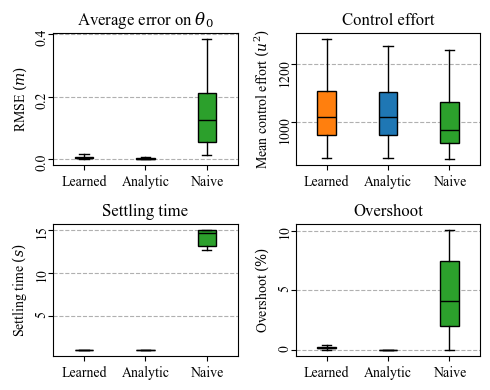

In [148]:
values_nn_undamped = [pdata_nn_sims["rmse_s"], pdata_nn_sims["control_effort_s"], pdata_nn_sims["settling_time_s"], pdata_nn_sims["overshoot_s"]]
values_ana_undamped = [pdata_ana_sims["rmse_s"], pdata_ana_sims["control_effort_s"], pdata_ana_sims["settling_time_s"], pdata_ana_sims["overshoot_s"]]
values_q_undamped = [pdata_naive_sims["rmse_s"], pdata_naive_sims["control_effort_s"], pdata_naive_sims["settling_time_s"], pdata_naive_sims["overshoot_s"]]
plot_titles_undamped = ["Average error on " + r"$\theta_0$", "Control effort", "Settling time", "Overshoot"]
ylabels_undamped = ["RMSE " + r"$(m)$", "Mean control effort " + r"$(u^2)$", "Settling time " + r"$(s)$", "Overshoot " + r"$(\%)$"]
yscientifics_undamped = [False, False, False, False]

make_boxplots_2x2(values_nn_undamped, values_ana_undamped, values_q_undamped, plot_titles_undamped, ylabels_undamped, yscientifics_undamped, save_name = "collocated_results/performance_logs/undamped/boxplot.pdf")

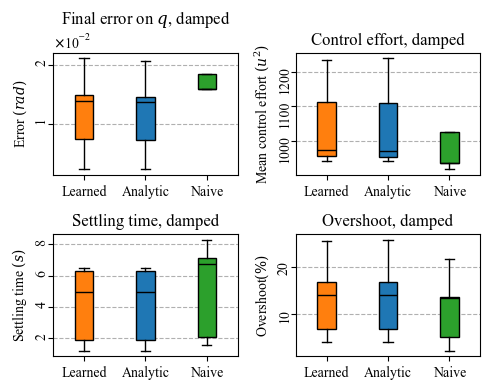

In [ ]:
values_nn_damp10 = [pdata_nn_sims_damp10["final_error_s"], pdata_nn_sims_damp10["control_effort_s"], pdata_nn_sims_damp10["settling_time_s"], pdata_nn_sims_damp10["overshoot_s"]]
values_ana_damp10 = [pdata_ana_sims_damp10["final_error_s"], pdata_ana_sims_damp10["control_effort_s"], pdata_ana_sims_damp10["settling_time_s"], pdata_ana_sims_damp10["overshoot_s"]]
values_q_damp10 = [pdata_naive_sims_damp10["final_error_s"], pdata_naive_sims_damp10["control_effort_s"], pdata_naive_sims_damp10["settling_time_s"], pdata_naive_sims_damp10["overshoot_s"]]
plot_titles_damp10 = ["Final error on " + r"$q$", "Control effort", "Settling time", "Overshoot"]
ylabels_damp10 = ["Error " + r"$(rad)$", "Mean control effort " + r"$(u^2)$", "Settling time " + r"$(s)$", "Overshoot" + r"$(\%)$"]
yscientifics_damp10 = [True, False, False, False]
ylims_damp10 = [None, None, None, None]

make_boxplots_2x2(values_nn_damp10, values_ana_damp10, values_q_damp10, plot_titles_damp10, ylabels_damp10, yscientifics_damp10, save_name = "collocated_results/performance_logs/damped_c=10/boxplot.pdf")

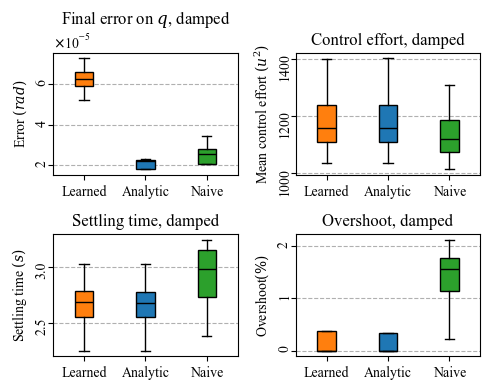

In [ ]:
values_nn_damp50 = [pdata_nn_sims_damp50["final_error_s"], pdata_nn_sims_damp50["control_effort_s"], pdata_nn_sims_damp50["settling_time_s"], pdata_nn_sims_damp50["overshoot_s"]]
values_ana_damp50 = [pdata_ana_sims_damp50["final_error_s"], pdata_ana_sims_damp50["control_effort_s"], pdata_ana_sims_damp50["settling_time_s"], pdata_ana_sims_damp50["overshoot_s"]]
values_q_damp50 = [pdata_naive_sims_damp50["final_error_s"], pdata_naive_sims_damp50["control_effort_s"], pdata_naive_sims_damp50["settling_time_s"], pdata_naive_sims_damp50["overshoot_s"]]
plot_titles_damp50 = ["Final error on " + r"$q$", "Control effort", "Settling time", "Overshoot"]
ylabels_damp50 = ["Error " + r"$(rad)$", "Mean control effort " + r"$(u^2)$", "Settling time " + r"$(s)$", "Overshoot" + r"$(\%)$"]
yscientifics_damp50 = [True, False, False, False]

make_boxplots_2x2(values_nn_damp50, values_ana_damp50, values_q_damp50, plot_titles_damp50, ylabels_damp50, yscientifics_damp50, save_name = "collocated_results/performance_logs/damped_c=50/boxplot.pdf")